In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, sum, min, rank, regexp_extract, lit, abs, lag, when, avg, current_date
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Create Spark session
spark = SparkSession.builder.getOrCreate()

In [2]:
# Read the CSV file
w = spark.read.csv("output.csv", header=True, inferSchema=True)

In [5]:
# GOAL-1 :
# In this goal, we are conducting a Supplier Performance Analysis based on retail and warehouse sales data. The objective is to evaluate the performance of each supplier by analyzing the total sales they contribute to both retail and warehouse channels.

# To achieve this, we are:

# Grouping the data by supplier.
# Calculating the total retail and warehouse sales for each supplier.
# Ordering the results based on the total retail sales in descending order.
# Selecting the supplier and total sales columns for visualization.
# The resulting visualization aims to provide insights into the contribution of each supplier to the overall sales, helping to identify top-performing suppliers and areas for potential improvement or optimization.
# # Define a window partitioned by 'SUPPLIER'
windowSpec = Window.partitionBy("SUPPLIER")

# Perform Supplier Performance Analysis
supplier_performance = w.withColumn("Total_Retail_Sales", sum("RETAIL SALES").over(windowSpec)) \
    .withColumn("Total_Warehouse_Sales", sum("WAREHOUSE SALES").over(windowSpec)) \
    .orderBy(col("Total_Retail_Sales").desc(), col("Total_Warehouse_Sales").desc()) \
    .select("SUPPLIER", "Total_Retail_Sales", "Total_Warehouse_Sales") \
    .distinct()


# Write the result to a CSV file, overwriting if it already exists
supplier_performance.coalesce(1).write.csv("supplier_performance_result", header=True, mode="overwrite")

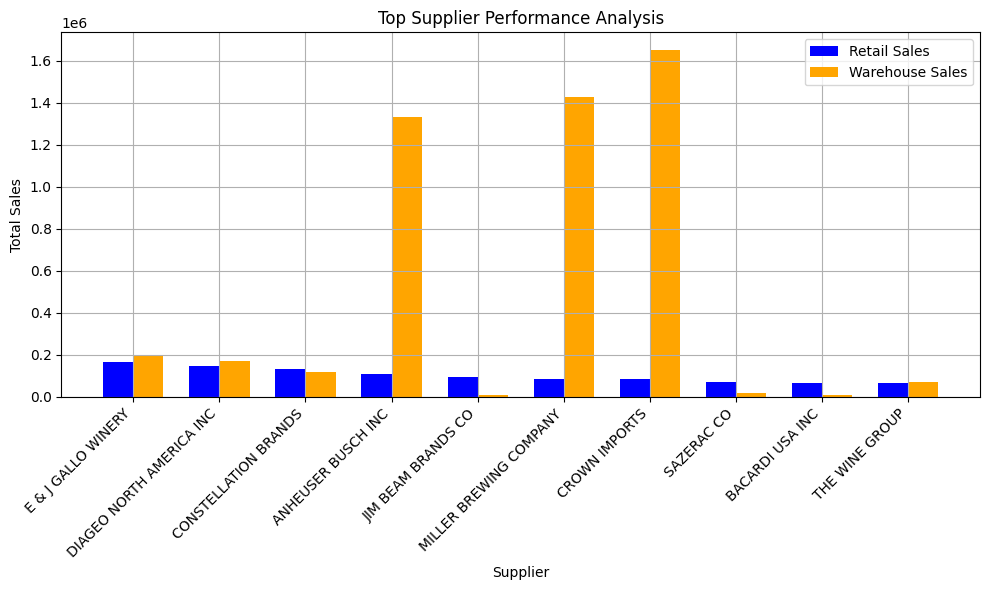

In [6]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
supplier_performance_df = supplier_performance.toPandas()

# Determine the number of top suppliers to display
top_n = 10  # Adjust this number as needed

# Select the top N suppliers based on total sales
top_suppliers = supplier_performance_df.nlargest(top_n, 'Total_Retail_Sales')

# Plot the data for the top supplier as a grouped bar chart
plt.figure(figsize=(10, 6))

# Define the positions for the bars
bar_width = 0.35
positions = range(len(top_suppliers))

# Plot retail sales
plt.bar(positions, top_suppliers["Total_Retail_Sales"], color='blue', width=bar_width, label='Retail Sales')

# Plot warehouse sales
plt.bar([pos + bar_width for pos in positions], top_suppliers["Total_Warehouse_Sales"], color='orange', width=bar_width, label='Warehouse Sales')

# Set x-axis labels and ticks
plt.xlabel('Supplier')
plt.xticks([pos + bar_width/2 for pos in positions], top_suppliers["SUPPLIER"], rotation=45, ha='right')

# Set y-axis label
plt.ylabel('Total Sales')

# Set plot title
plt.title('Top Supplier Performance Analysis')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [4]:
# Goal 2: Retail vs. Warehouse Sales Discrepancy Investigation
# Investigate and reconcile discrepancies between Retail Sales and Warehouse Sales data.

# Calculate the absolute difference between Retail Sales and Warehouse Sales
w = w.withColumn("Sales_Discrepancy", abs(col("RETAIL SALES") - col("WAREHOUSE SALES")))

# Show rows where the Sales Discrepancy is greater than 0
discrepancies = w.filter(col("Sales_Discrepancy") > 0)

# Show the result
discrepancies.select("SUPPLIER", "ITEM CODE", "ITEM DESCRIPTION", "RETAIL SALES", "WAREHOUSE SALES", "Sales_Discrepancy").show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `ITEM_CODE` cannot be resolved. Did you mean one of the following? [`ITEM CODE`, `ITEM TYPE`, `MONTH`, `YEAR`, `SUPPLIER`].;
'Aggregate ['ITEM_CODE, 'ITEM_DESCRIPTION], ['ITEM_CODE, 'ITEM_DESCRIPTION, avg(Inventory_Age#64) AS Average_Inventory_Age#88, max(Inventory_Age#64) AS Oldest_Inventory_Age#90, min(Inventory_Age#64) AS Youngest_Inventory_Age#92]
+- Project [YEAR#17, MONTH#18, SUPPLIER#19, ITEM CODE#20, ITEM DESCRIPTION#21, ITEM TYPE#22, RETAIL SALES#23, RETAIL TRANSFERS#24, WAREHOUSE SALES#25, RETAIL_TRANSFERS#53, RETAIL_TRANSFERS#53 AS Inventory_Age#64]
   +- Project [YEAR#17, MONTH#18, SUPPLIER#19, ITEM CODE#20, ITEM DESCRIPTION#21, ITEM TYPE#22, RETAIL SALES#23, RETAIL TRANSFERS#24, WAREHOUSE SALES#25, cast(RETAIL TRANSFERS#24 as double) AS RETAIL_TRANSFERS#53]
      +- Relation [YEAR#17,MONTH#18,SUPPLIER#19,ITEM CODE#20,ITEM DESCRIPTION#21,ITEM TYPE#22,RETAIL SALES#23,RETAIL TRANSFERS#24,WAREHOUSE SALES#25] csv


In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
discrepancies_df = discrepancies.select("YEAR", "MONTH", "RETAIL SALES", "WAREHOUSE SALES").toPandas()

# Combine Year and Month into a single date column for plotting
discrepancies_df['Date'] = pd.to_datetime(discrepancies_df[['YEAR', 'MONTH']].assign(DAY=1))

# Plot the data
plt.figure(figsize=(12, 8))

# Plot retail sales
plt.plot(discrepancies_df['Date'], discrepancies_df['RETAIL SALES'], marker='o', linestyle='-', color='blue', label='Retail Sales')

# Plot warehouse sales
plt.plot(discrepancies_df['Date'], discrepancies_df['WAREHOUSE SALES'], marker='o', linestyle='-', color='orange', label='Warehouse Sales')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Trend of Retail and Warehouse Sales Over Time')
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [8]:
# Goal 3: Item Type Analysis
# Analyze sales performance based on different Item Types and identify trends among customers.
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Create Spark session
spark = SparkSession.builder.getOrCreate()

# Read the CSV file
w = spark.read.csv("output.csv", header=True, inferSchema=True)

# Group by 'ITEM TYPE' and calculate sum of 'RETAIL SALES' and 'WAREHOUSE SALES'
item_type_sales = w.groupBy("ITEM TYPE") \
    .agg(sum("RETAIL SALES").alias("Total_Retail_Sales"),
         sum("WAREHOUSE SALES").alias("Total_Warehouse_Sales")) \
    .orderBy("ITEM TYPE")

# Show the result
item_type_sales.show(truncate=False)


+-----------------------+------------------+---------------------+
|ITEM TYPE              |Total_Retail_Sales|Total_Warehouse_Sales|
+-----------------------+------------------+---------------------+
| DOMAINE PIRON - 750ML"|NULL              |0.0                  |
|BEER                   |574220.5299999997 |6527236.509999999    |
|DUNNAGE                |0.0               |-121454.0            |
|KEGS                   |0.0               |118431.0             |
|LIQUOR                 |802691.4299999962 |94906.27             |
|NON-ALCOHOL            |34084.30999999999 |26149.59             |
|REF                    |663.6299999999999 |-20499.0             |
|STR_SUPPLIES           |2740.8799999999997|0.0                  |
|WINE                   |746498.5900000321 |1156982.9100000008   |
+-----------------------+------------------+---------------------+



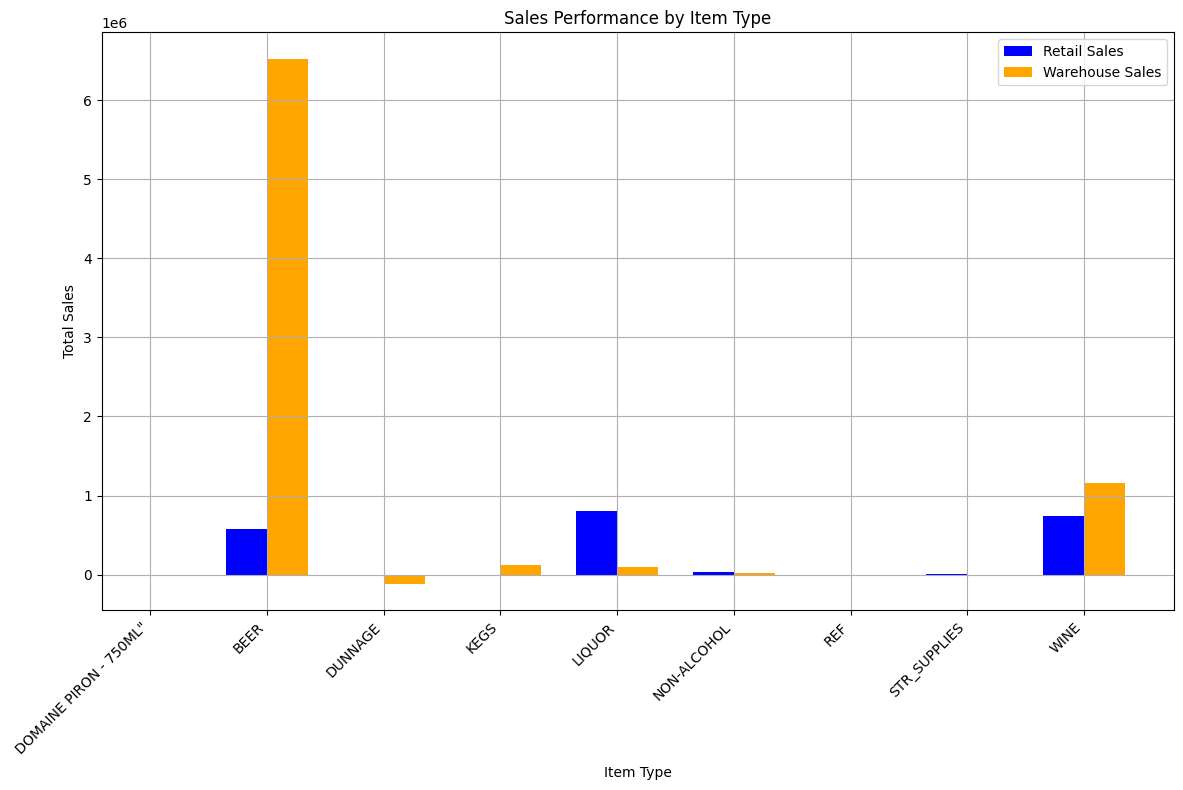

In [13]:
# Set the width of the bars
bar_width = 0.35

# Convert Spark DataFrame to Pandas DataFrame for visualization
item_type_sales_df = item_type_sales.toPandas()

# Get the index for the x-axis
x_index = np.arange(len(item_type_sales_df))

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the total retail sales for each item type
plt.bar(x_index - bar_width/2, item_type_sales_df["Total_Retail_Sales"], width=bar_width, color='blue', label='Retail Sales')

# Plot the total warehouse sales for each item type
plt.bar(x_index + bar_width/2, item_type_sales_df["Total_Warehouse_Sales"], width=bar_width, color='orange', label='Warehouse Sales')

# Set labels and title
plt.xlabel('Item Type')
plt.ylabel('Total Sales')
plt.title('Sales Performance by Item Type')
plt.xticks(x_index, item_type_sales_df["ITEM TYPE"], rotation=45, ha='right')  # Rotate labels and align to the right
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [14]:

# Goal 4: Seasonal Sales Patterns
# Identify seasonal patterns in Retail Sales and Warehouse Sales for better inventory management.
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F

# Create Spark session
spark = SparkSession.builder.getOrCreate()

# Read the CSV file
w = spark.read.csv("output.csv", header=True, inferSchema=True)

# Convert 'RETAIL SALES' and 'WAREHOUSE SALES' to float
w = w.withColumn("RETAIL SALES", col("RETAIL SALES").cast("float"))
w = w.withColumn("WAREHOUSE SALES", col("WAREHOUSE SALES").cast("float"))

# Group by 'YEAR' and 'MONTH', calculate the average sales
seasonal_sales = w.groupBy("YEAR", "MONTH") \
    .agg(F.avg("RETAIL SALES").alias("Avg_Retail_Sales"),
         F.avg("WAREHOUSE SALES").alias("Avg_Warehouse_Sales")) \
    .orderBy("YEAR", "MONTH")

# Show the result
seasonal_sales.show(truncate=False)


+----+-----+------------------+-------------------+
|YEAR|MONTH|Avg_Retail_Sales  |Avg_Warehouse_Sales|
+----+-----+------------------+-------------------+
|2017|6    |7.143913998506091 |27.83906883082241  |
|2017|7    |7.112984958381855 |24.332152454008284 |
|2017|8    |6.409991166960363 |28.122640918286805 |
|2017|9    |6.757253846613921 |22.817909019589692 |
|2017|10   |6.549020991309067 |22.289366649873593 |
|2017|11   |6.7654961425708   |23.348861778558465 |
|2017|12   |9.078240692246963 |21.169463461764927 |
|2018|1    |5.6794132634064995|19.072137154842547 |
|2018|2    |5.93924656892039  |20.229657956310582 |
|2019|1    |6.141101521517862 |22.62598771643401  |
|2019|2    |6.519126049960371 |20.228470981013146 |
|2019|3    |6.657812819878075 |23.122346444323753 |
|2019|4    |6.309296360651877 |23.467949539727236 |
|2019|5    |7.333418293085018 |29.640993105332203 |
|2019|6    |7.369050284692926 |28.109252240898545 |
|2019|7    |7.2622403613442055|30.00251868941995  |
|2019|8    |

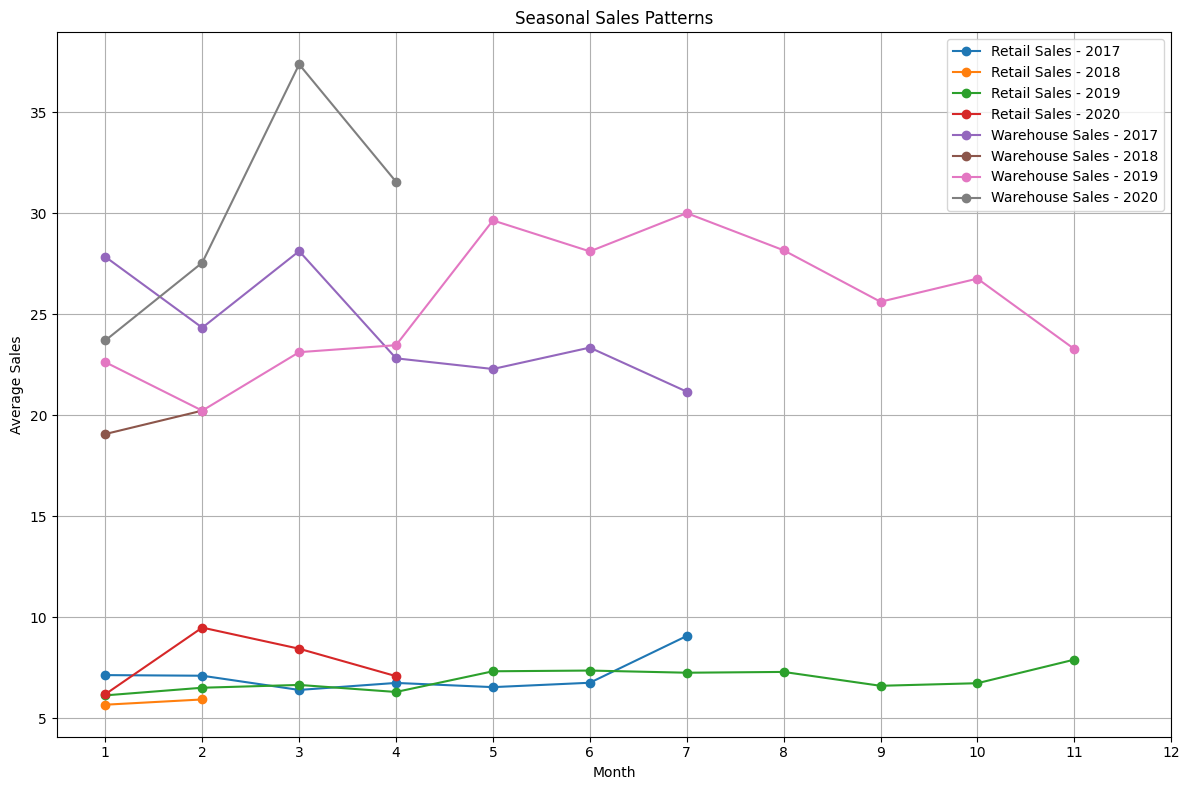

In [17]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
seasonal_sales_df = seasonal_sales.toPandas()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the average retail sales over months for each year
for year in seasonal_sales_df["YEAR"].unique():
    retail_sales_for_year = seasonal_sales_df[seasonal_sales_df["YEAR"] == year]["Avg_Retail_Sales"]
    months = range(1, len(retail_sales_for_year) + 1)  # Generate months from 1 to the length of retail_sales_for_year
    plt.plot(months, retail_sales_for_year, marker='o', label=f'Retail Sales - {year}')

# Plot the average warehouse sales over months for each year
for year in seasonal_sales_df["YEAR"].unique():
    warehouse_sales_for_year = seasonal_sales_df[seasonal_sales_df["YEAR"] == year]["Avg_Warehouse_Sales"]
    months = range(1, len(warehouse_sales_for_year) + 1)  # Generate months from 1 to the length of warehouse_sales_for_year
    plt.plot(months, warehouse_sales_for_year, marker='o', label=f'Warehouse Sales - {year}')

plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Seasonal Sales Patterns')
plt.xticks(range(1, 13))  # Assuming 12 months in a year
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Goal 5: Supplier Diversity Assessment
# Assess the diversity of suppliers based on various criteria and enhance supplier diversity.
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct

# Create Spark session
spark = SparkSession.builder.getOrCreate()

# Read the CSV file
w = spark.read.csv("output.csv", header=True, inferSchema=True)

# Group by 'SUPPLIER' and count distinct 'ITEM TYPE' and 'ITEM DESCRIPTION'
supplier_diversity = w.groupBy("SUPPLIER") \
    .agg(countDistinct("ITEM TYPE").alias("Unique_Item_Types"),
         countDistinct("ITEM DESCRIPTION").alias("Unique_Item_Descriptions")) \
    .orderBy("SUPPLIER")

# Show the result
# Write the result to a CSV file
supplier_diversity.coalesce(1).write.csv("supplier_diversity_result", header=True, mode="overwrite")

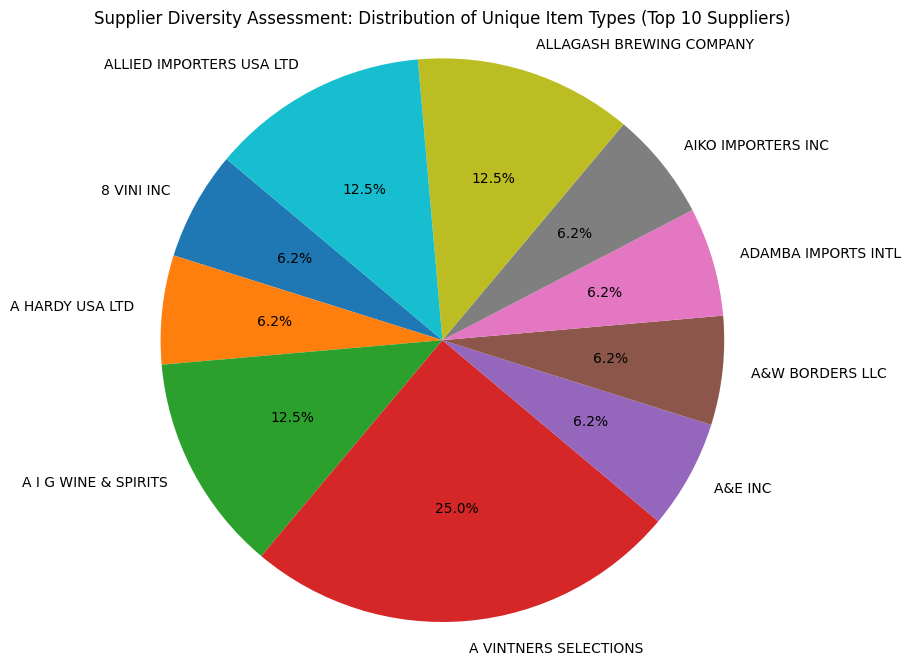

In [25]:
# Select the top 10 suppliers and convert to Pandas DataFrame
top_10_suppliers = supplier_diversity.limit(10).toPandas()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_suppliers["Unique_Item_Types"], labels=top_10_suppliers["SUPPLIER"], autopct='%1.1f%%', startangle=140)
plt.title('Supplier Diversity Assessment: Distribution of Unique Item Types (Top 10 Suppliers)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [32]:
# Goal 6: Inventory Turnover Optimization
# Calculate and analyze Inventory Turnover ratios for each item.
# Identify slow-moving items and implement strategies to optimize inventory turnover rates.
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, lag
from pyspark.sql.window import Window

# Create Spark session
spark = SparkSession.builder.getOrCreate()

# Read the CSV file
w = spark.read.csv("output.csv", header=True, inferSchema=True)

# Calculate total sales for each item
item_sales = w.groupBy("ITEM CODE", "ITEM DESCRIPTION") \
    .agg(sum("RETAIL SALES").alias("Total_Retail_Sales"),
         sum("WAREHOUSE SALES").alias("Total_Warehouse_Sales")) \
    .orderBy("ITEM CODE")

# Calculate Inventory Turnover ratio
windowSpec = Window.partitionBy("ITEM CODE").orderBy("ITEM CODE")
item_sales = item_sales.withColumn("Lagged_Total_Sales",
                                   lag(item_sales["Total_Retail_Sales"] + item_sales["Total_Warehouse_Sales"]).over(windowSpec))

item_sales = item_sales.withColumn("Inventory_Turnover_Ratio",
                                   (item_sales["Total_Retail_Sales"] + item_sales["Total_Warehouse_Sales"]) /
                                   item_sales["Lagged_Total_Sales"])

# Identify slow-moving items (e.g., Inventory Turnover < 1)
slow_moving_items = item_sales.filter(col("Inventory_Turnover_Ratio") < 1)

# Show the result
slow_moving_items.show(truncate=False)


+---------+---------------------------------------+------------------+---------------------+------------------+------------------------+
|ITEM CODE|ITEM DESCRIPTION                       |Total_Retail_Sales|Total_Warehouse_Sales|Lagged_Total_Sales|Inventory_Turnover_Ratio|
+---------+---------------------------------------+------------------+---------------------+------------------+------------------------+
|1001     |S SMITH ORGANIC PEAR CIDER - 18.7OZ    |0.0               |7.0                  |35.97             |0.19460661662496526     |
|100293   |SANTA MARGHERITA P/GRIG ALTO - 375ML   |0.08              |1.0                  |134.86            |0.008008304908794305    |
|101664   |RAMON CARDOVA RIOJA - 750ML            |0.24              |2.0                  |46.620000000000005|0.04804804804804805     |
|10356    |TROEGS NUGGET NECTAR 4/6 CANS          |0.75              |5.0                  |21.0              |0.27380952380952384     |
|10431    |VICTORY GOLDEN MONKEY 4/6 NR  

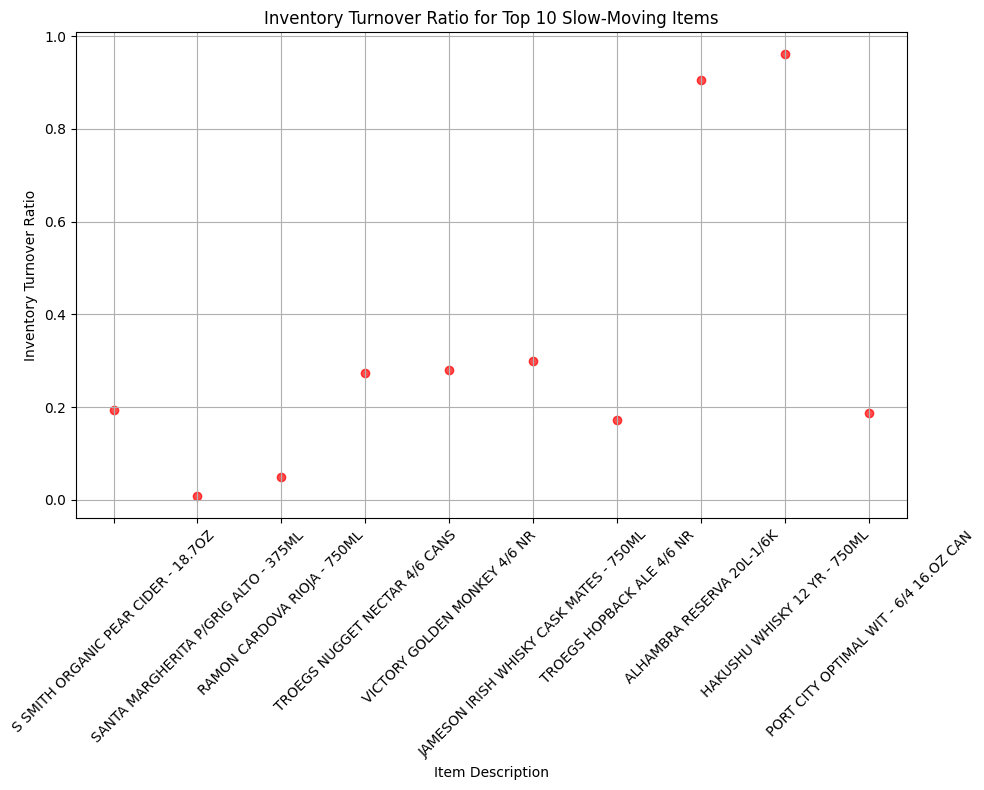

In [37]:
# Plot the data using a scatter plot for the top 10 slow-moving items
plt.figure(figsize=(10, 8))
plt.scatter(slow_moving_items_pd["ITEM DESCRIPTION"][:10], slow_moving_items_pd["Inventory_Turnover_Ratio"][:10], color='red', alpha=0.7)
plt.xlabel('Item Description')
plt.ylabel('Inventory Turnover Ratio')
plt.title('Inventory Turnover Ratio for Top 10 Slow-Moving Items')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Goal 7: Supplier Profitability Analysis
# Analyze the profitability of each supplier based on the difference between Retail Sales and Warehouse Costs.
# Identify suppliers with the highest profit margins to strengthen partnerships and optimize procurement strategies.

# Calculate Profit Margin for each Supplier
supplier_profitability = w.groupBy("SUPPLIER") \
    .agg((sum("RETAIL SALES") - sum("WAREHOUSE SALES")).alias("Profit")) \
    .orderBy("Profit", ascending=False)


# Write the result to a CSV file
supplier_profitability.coalesce(1).write.csv("supplier_profit_result", header=True, mode="overwrite")

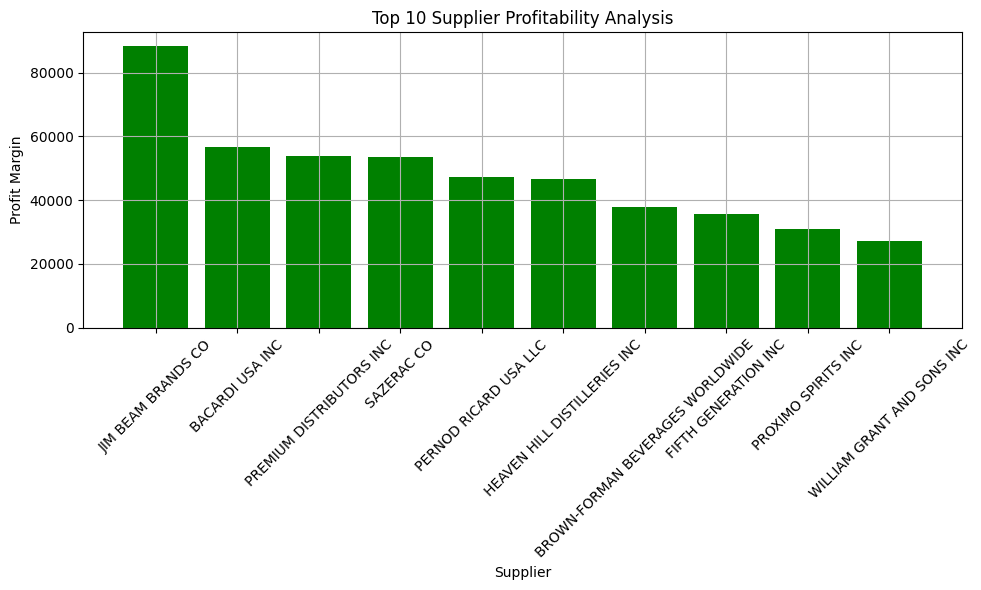

In [44]:
# Convert the Spark DataFrame to a Pandas DataFrame for visualization
supplier_profitability_pd = supplier_profitability.limit(10).toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(supplier_profitability_pd["SUPPLIER"], supplier_profitability_pd["Profit"], color='green')
plt.xlabel('Supplier')
plt.ylabel('Profit Margin')
plt.title('Top 10 Supplier Profitability Analysis')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Goal 8: Item Code Validation
# Implement a validation process for Item Codes to ensure consistency and accuracy in inventory records.
# Identify and correct any inconsistencies or errors in the Item Codes.

# Check for item codes with multiple descriptions
item_code_validation = w.groupBy("ITEM CODE") \
    .agg(countDistinct("ITEM DESCRIPTION").alias("Unique_Descriptions")) \
    .filter(col("Unique_Descriptions") > 1) \
    .orderBy("ITEM CODE")

# Show the result
item_code_validation.show(truncate=False)

+---------+-------------------+
|ITEM CODE|Unique_Descriptions|
+---------+-------------------+
|1001     |2                  |
|100293   |3                  |
|101664   |2                  |
|10356    |2                  |
|10431    |2                  |
|10444    |2                  |
|10491    |2                  |
|1058     |2                  |
|10586    |2                  |
|10636    |2                  |
|10715    |2                  |
|10818    |2                  |
|10909    |2                  |
|10910    |2                  |
|10931    |3                  |
|10932    |2                  |
|10936    |2                  |
|10940    |2                  |
|11055    |2                  |
|11056    |2                  |
+---------+-------------------+
only showing top 20 rows



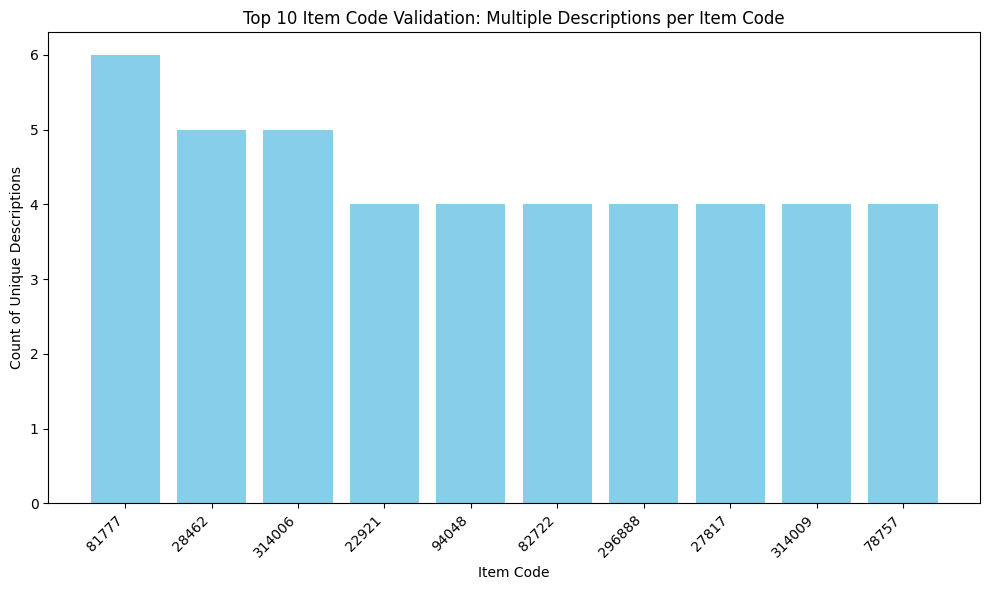

In [48]:
# Convert DataFrame to Pandas for visualization and filter top 10 items
top_10_items_df = item_code_validation.orderBy("Unique_Descriptions", ascending=False).limit(10).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_10_items_df["ITEM CODE"], top_10_items_df["Unique_Descriptions"], color='skyblue')
plt.xlabel('Item Code')
plt.ylabel('Count of Unique Descriptions')
plt.title('Top 10 Item Code Validation: Multiple Descriptions per Item Code')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
# Partition the data by product category and region
windowSpec = Window.partitionBy("Product_Category", "Region")

# Aggregate sales information by product category and region
category_region_sales = w \
    .groupBy("Product_Category", "Region") \
    .agg(sum("Sales_Amount").alias("Total_Sales_Amount"),
         max("Sales_Amount").alias("Max_Single_Sale"),
         sum("Units_Sold").alias("Total_Units_Sold"),
         max("Units_Sold").alias("Max_Single_Sale_Units")) \
    .withColumn("Total_Sales_Amount_Per_Category_Region",
                sum("Total_Sales_Amount").over(windowSpec))

# Identify top-performing products in each category within each region
top_products_window = Window.partitionBy("Product_Category", "Region").orderBy(col("Total_Sales_Amount").desc())
top_products = category_region_sales \
    .withColumn("Rank", rank().over(top_products_window)) \
    .filter(col("Rank") == 1)

# Show the top-performing products in each category within each region
top_products.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Product_Category` cannot be resolved. Did you mean one of the following? [`ITEM CODE`, `ITEM TYPE`, `MONTH`, `RETAIL SALES`, `SUPPLIER`].;
'Aggregate ['Product_Category, 'Region], ['Product_Category, 'Region, sum('Sales_Amount) AS Total_Sales_Amount#45, max('Sales_Amount) AS Max_Single_Sale#47, sum('Units_Sold) AS Total_Units_Sold#49, max('Units_Sold) AS Max_Single_Sale_Units#51]
+- Relation [YEAR#17,MONTH#18,SUPPLIER#19,ITEM CODE#20,ITEM DESCRIPTION#21,ITEM TYPE#22,RETAIL SALES#23,RETAIL TRANSFERS#24,WAREHOUSE SALES#25] csv


In [ ]:
# Filter the Spark DataFrame to include only the first 10 records
inventory_age_first_10 = inventory_age.select('ITEM DESCRIPTION', 'Average_Inventory_Age') \
    .limit(10) \
    .toPandas()

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the average inventory age for the first 10 items
plt.bar(inventory_age_first_10['ITEM DESCRIPTION'], inventory_age_first_10['Average_Inventory_Age'], color='blue')

# Add labels and title
plt.xlabel('Item Description')
plt.ylabel('Average Inventory Age')
plt.title('Average Inventory Age for First 10 Items')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align to the right
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In [4]:
# Goal 10: Customer Segmentation Analysis
# Segment customers based on their purchasing behavior and preferences.
# Identify distinct customer groups for targeted marketing and personalized promotions.

# Define conditions for customer segmentation
w = w.withColumn("Customer_Segment",
                 when(col("RETAIL SALES") > 5000, "High Value Customer")
                 .when((col("RETAIL SALES") > 1000) & (col("RETAIL SALES") <= 5000), "Medium Value Customer")
                 .otherwise("Low Value Customer"))

# Count the number of customers in each segment
customer_segment_count = w.groupBy("Customer_Segment").count()

# Show the result
customer_segment_count.show()


+--------------------+------+
|    Customer_Segment| count|
+--------------------+------+
|Medium Value Cust...|    33|
|  Low Value Customer|307612|
+--------------------+------+



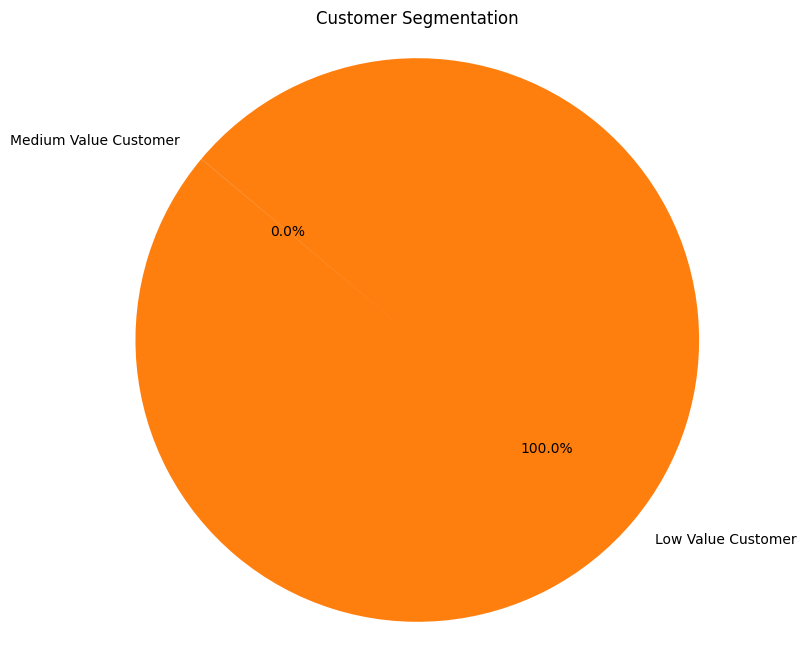

In [6]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
customer_segment_count_df = customer_segment_count.toPandas()

# Plot the data
plt.figure(figsize=(8, 8))
plt.pie(customer_segment_count_df['count'], labels=customer_segment_count_df['Customer_Segment'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Customer Segmentation')
plt.show()